# Лабораторная работа №6. Временные ряды.

In [1]:
import pandas as pd

**1. Загрузить данные...**

In [2]:
df = pd.read_csv("train.csv")

In [ ]:
X = df[(df['item'] == 1) & (df['store'] == 1)][['date', 'sales']]
X['date'] = pd.to_datetime(X.date)
X_train = X[X.date < '2017-01-01']
X_test = X[X.date >= '2017-01-01']

Визуализация временного ряда для 1 item и 1 store

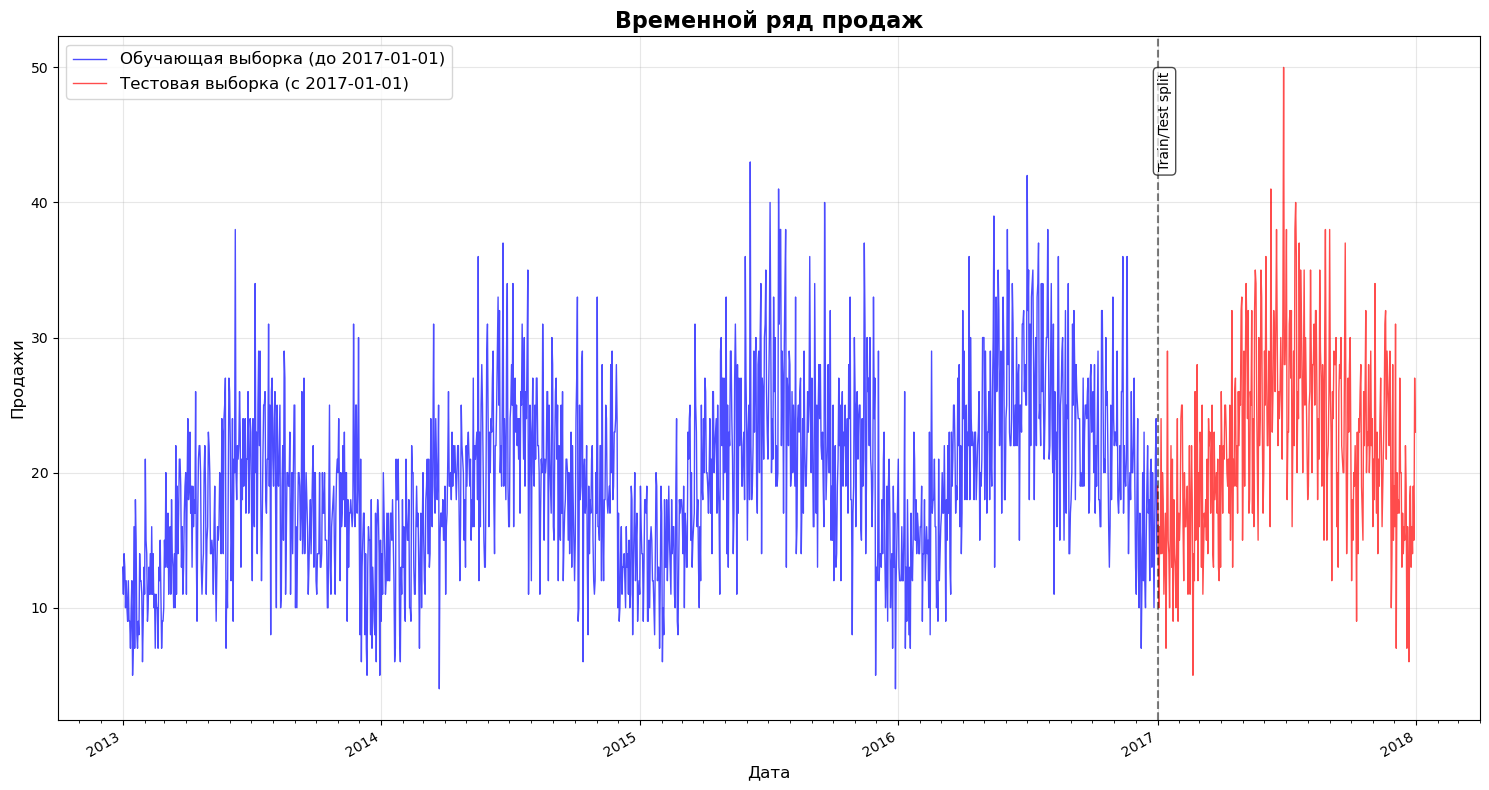

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Создаем график
plt.figure(figsize=(15, 8))

# Визуализируем обучающую выборку
plt.plot(X_train['date'], X_train['sales'], 
         color='blue', alpha=0.7, linewidth=1, 
         label='Обучающая выборка (до 2017-01-01)')

# Визуализируем тестовую выборку
plt.plot(X_test['date'], X_test['sales'], 
         color='red', alpha=0.7, linewidth=1, 
         label='Тестовая выборка (с 2017-01-01)')

# Настройки графика
plt.title('Временной ряд продаж', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Форматирование оси дат для лучшей читаемости
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Добавляем вертикальную линию для разделения выборок
plt.axvline(x=pd.to_datetime('2017-01-01'), 
           color='black', linestyle='--', alpha=0.5, 
           label='Разделение на train/test')

# Добавляем аннотацию для линии разделения
plt.text(pd.to_datetime('2017-01-01'), plt.ylim()[1]*0.95, 
         'Train/Test split', rotation=90, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Улучшаем визуализацию сезонности
# Можно добавить подсветку одинаковых месяцев для лучшего видения сезонности
plt.tight_layout()
plt.show()

Видно, что пики продаж приходятся на середину года (примерно на лето), а спады в конце-начале (зимой). То  есть на данный товар спрос летом сильно выше.

**2. Разложить обучающий ряд на статистические компоненты - тренд, сезонность и остатки**

In [13]:
# Устанавливаем дату в качестве индекса
X_train_indexed = X_train.set_index('date')
X_test_indexed = X_test.set_index('date')

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(X_train_indexed, period=365)
print(f"Сезонная компонента: {decompose_result.seasonal.head()}")
print(f"Trend компонента: {decompose_result.trend.head()}")
print(f"Остаточная компонента: {decompose_result.resid.head()}")
print(f"Веса: {decompose_result.weights}")

Сезонная компонента: date
2013-01-01   -5.847145
2013-01-02   -4.198743
2013-01-03   -6.542122
2013-01-04   -4.209702
2013-01-05   -5.223401
Name: seasonal, dtype: float64
Trend компонента: date
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
Name: trend, dtype: float64
Остаточная компонента: date
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
Name: resid, dtype: float64
Веса: date
2013-01-01    1.0
2013-01-02    1.0
2013-01-03    1.0
2013-01-04    1.0
2013-01-05    1.0
             ... 
2016-12-27    1.0
2016-12-28    1.0
2016-12-29    1.0
2016-12-30    1.0
2016-12-31    1.0
Name: weights, Length: 1461, dtype: float64


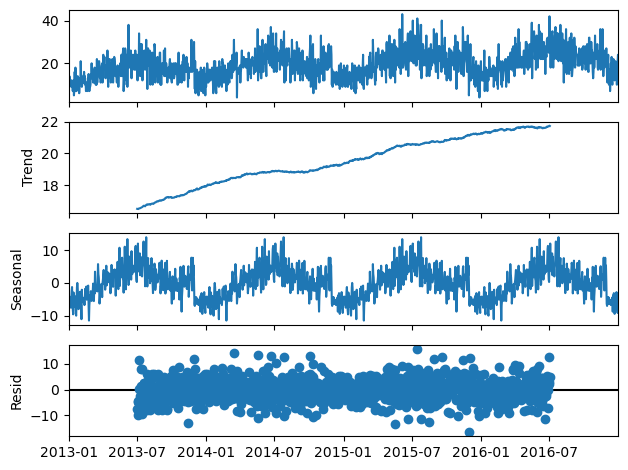

In [30]:
decompose_result.plot()
plt.show()

Строим графики автокорреляционной функции

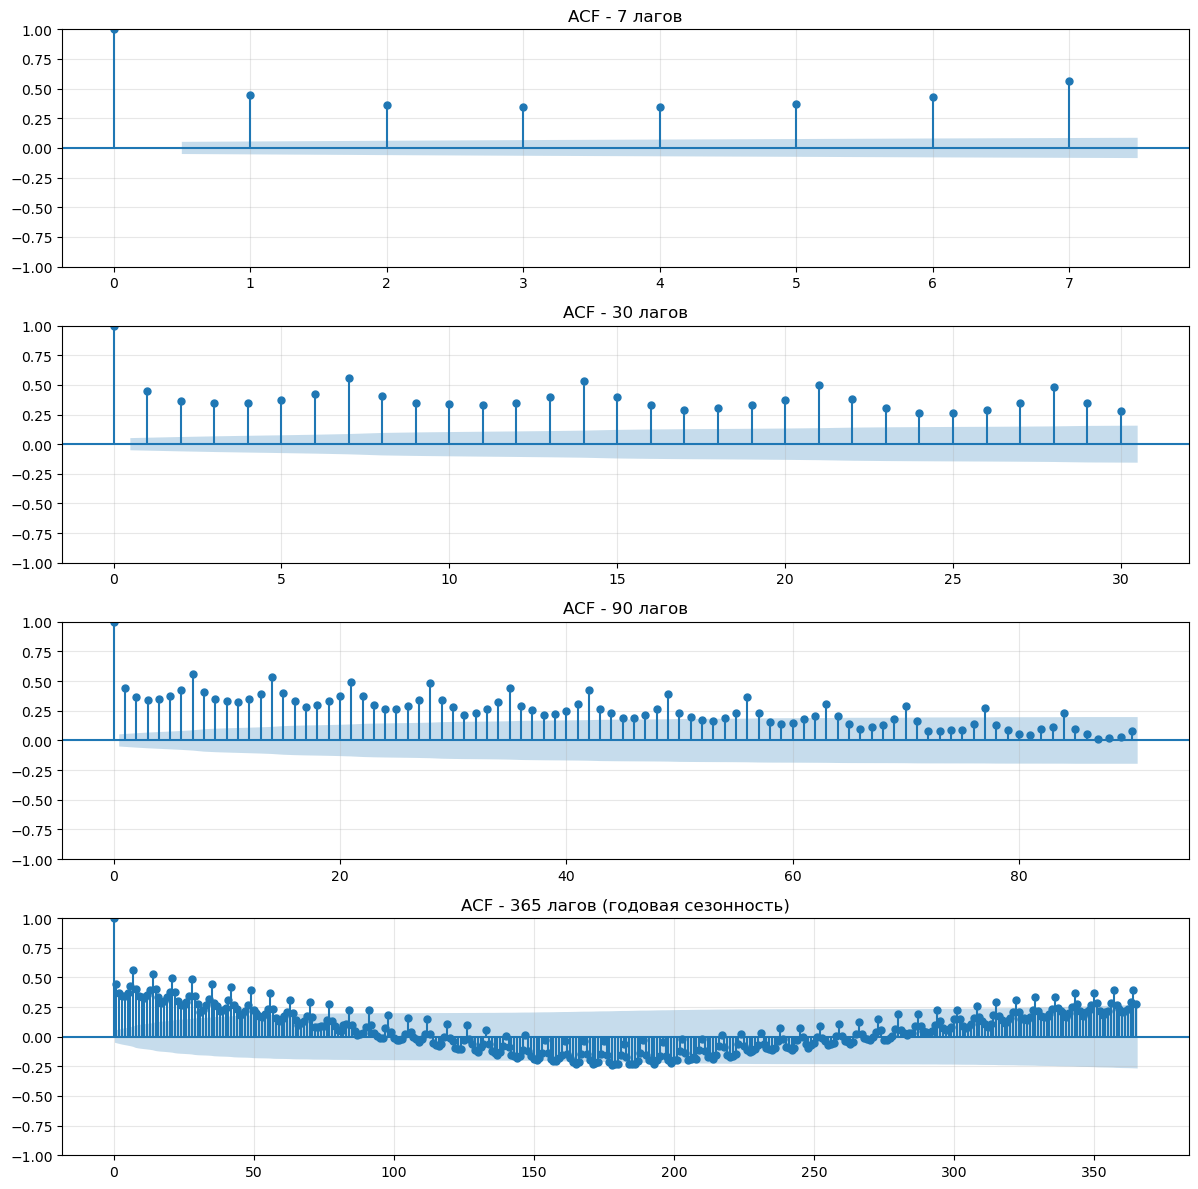

In [42]:
from statsmodels.graphics.tsaplots import plot_acf

# 4 варианта лагов на одном графике
fig, axes = plt.subplots(4, 1, figsize=(12, 12))

plot_acf(X_train_indexed, lags=7, alpha=0.05, ax=axes[0])
axes[0].set_title('ACF - 7 лагов')
axes[0].grid(alpha=0.3)

plot_acf(X_train_indexed, lags=30, alpha=0.05, ax=axes[1])
axes[1].set_title('ACF - 30 лагов')
axes[1].grid(alpha=0.3)

plot_acf(X_train_indexed, lags=90, alpha=0.05, ax=axes[2])
axes[2].set_title('ACF - 90 лагов')
axes[2].grid(alpha=0.3)

plot_acf(X_train_indexed, lags=365, alpha=0.05, ax=axes[3])
axes[3].set_title('ACF - 365 лагов (годовая сезонность)')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод:** По графикам можно наблюдать недельную сезонность и годовую. Соответственно для модели имеет смысл использовать lag7 и lag365

**3. Представить временной ряд в виде матрицы признаков от дат. Добавить лаговые признаки.**

In [ ]:
import pandas as pd
import numpy as np

# Копируем данные
X_train_features = X_train_indexed.copy()
X_test_features = X_test_indexed.copy()

# Добавляем лаговые признаки сразу без nan
lags = [1, 7, 365] 

for lag in lags:
    X_train_features[f'lag_{lag}'] = X_train_features['sales'].shift(lag)
    X_test_features[f'lag_{lag}'] = X_test_features['sales'].shift(lag)
    X_train_features[f'lag_{lag}'] = X_train_features[f'lag_{lag}'].fillna(X_train_features['sales'].mean())
    X_test_features[f'lag_{lag}'] = X_test_features[f'lag_{lag}'].fillna(X_test_features['sales'].mean())

In [ ]:
# Добавляем скользящие средние (moving averages) без nan
windows = [3, 7, 30]

for window in windows:
    X_train_features[f'ma_{window}'] = X_train_features['sales'].rolling(window=window, min_periods=1).mean()
    X_test_features[f'ma_{window}'] = X_test_features['sales'].rolling(window=window, min_periods=1).mean()

**4. Обучить модели экспоненциального сглаживания с трендом и сезонностью и градиентный бустинг. Для градиентного бустинга реализовать рекурсивную стратегию прогнозирования.**

Обучение модели Хольта-Винтерса...


c:\Users\smolk\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Хольт-Винтерс результаты:
MAE: 5.52
RMSE: 7.01
R2: -0.02


c:\Users\smolk\miniconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


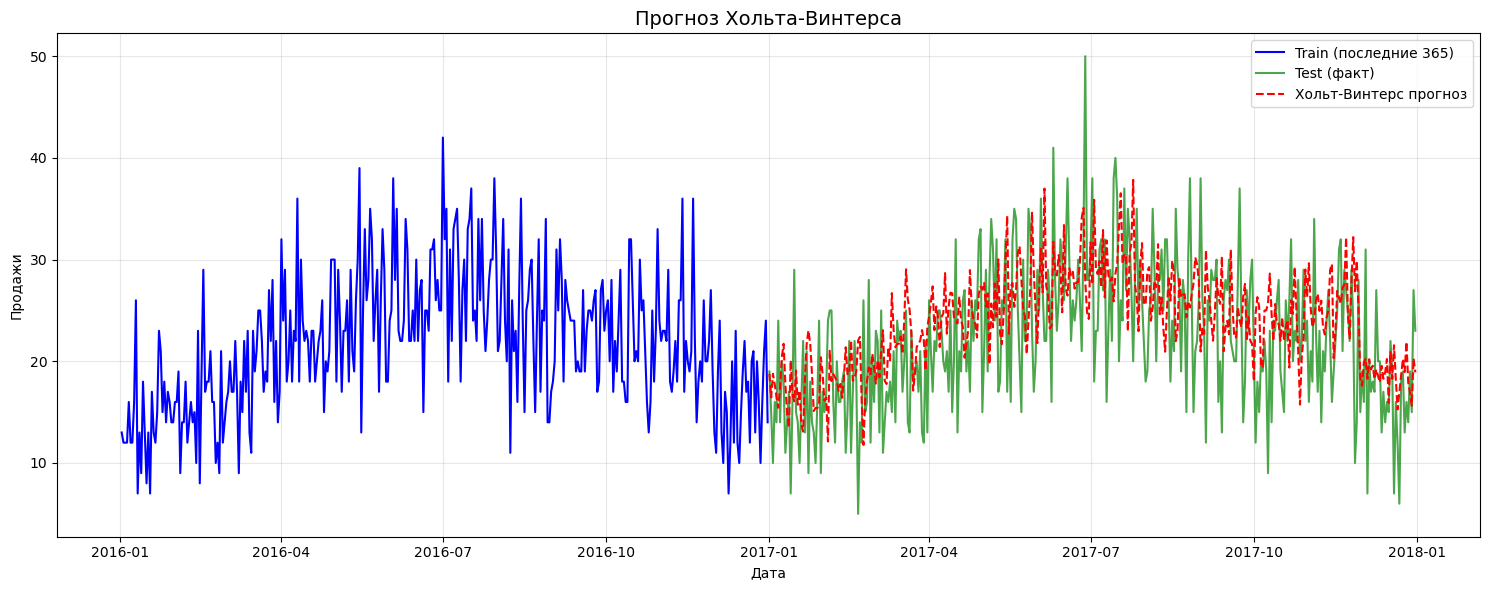

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Подготовка данных для Хольта-Винтерса
hw_train = X_train_indexed['sales']
hw_test = X_test_indexed['sales']

# Обучаем модель Хольта-Винтерса с аддитивной сезонностью
print("Обучение модели Хольта-Винтерса...")
hw_model = ExponentialSmoothing(
    hw_train,
    seasonal='additive',  # аддитивная сезонность
    seasonal_periods=365,  # годовая сезонность для дневных данных
    trend='additive'      # аддитивный тренд
).fit()

# Прогноз на длину тестовой выборки
hw_forecast = hw_model.forecast(len(hw_test))

# Оценка качества
hw_mae = mean_absolute_error(hw_test, hw_forecast)
hw_rmse = root_mean_squared_error(hw_test, hw_forecast)
hw_r2 = r2_score(hw_test, hw_forecast)

print(f"Хольт-Винтерс результаты:")
print(f"MAE: {hw_mae:.2f}")
print(f"RMSE: {hw_rmse:.2f}")
print(f"R2: {hw_r2:.2f}")

# Визуализация прогноза
plt.figure(figsize=(15, 6))
plt.plot(hw_train.index[-365:], hw_train[-365:], label='Train (последние 365)', color='blue')
plt.plot(hw_test.index, hw_test, label='Test (факт)', color='green', alpha=0.7)
plt.plot(hw_test.index, hw_forecast, label='Хольт-Винтерс прогноз', color='red', linestyle='--')
plt.title('Прогноз Хольта-Винтерса', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [63]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

# Разделение на признаки и целевую переменную
X_train = X_train_features.drop('sales', axis=1)
y_train = X_train_features['sales']
X_test = X_test_features.drop('sales', axis=1)
y_test = X_test_features['sales']

print(f"Размеры данных для градиентного бустинга:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Обучение модели CatBoost
print("\nОбучение CatBoost модели...")
gb_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    random_state=42
)

gb_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

y_pred = gb_model.predict(X_test)

# Оценка качества
gb_mae = mean_absolute_error(y_test, y_pred)
gb_rmse = root_mean_squared_error(y_test, y_pred)
gb_r2 = r2_score(y_test, y_pred)

print(f"Градиентный бустинг:")
print(f"MAE: {gb_mae:.2f}")
print(f"RMSE: {gb_rmse:.2f}")
print(f"R2: {gb_r2:.2f}")


Размеры данных для градиентного бустинга:
X_train: (1461, 6), y_train: (1461,)
X_test: (365, 6), y_test: (365,)

Обучение CatBoost модели...
0:	learn: 6.4038839	test: 7.2718497	best: 7.2718497 (0)	total: 153ms	remaining: 2m 32s
100:	learn: 3.5261292	test: 4.1381616	best: 4.1381616 (100)	total: 245ms	remaining: 2.18s
200:	learn: 3.2266426	test: 4.0657672	best: 4.0631153 (171)	total: 333ms	remaining: 1.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.054101325
bestIteration = 244

Shrink model to first 245 iterations.
Градиентный бустинг:
MAE: 3.17
RMSE: 4.05
R2: 0.66
